In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kr_helper_funcs as kr
from sklearn.preprocessing import MinMaxScaler
import kr_helper_funcs as kr
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from lime import lime_tabular
import shap
import tensorflow_addons as tfa
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [88]:
name = 'without_postcode'
fileName = "{}/lending-club-values.csv".format(name)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model = tf.keras.models.load_model('{}/lending-club.h5'.format(name), custom_objects={"f1": kr.f1, "optimizer": ranger})
X_train_unscaled = np.load("{}/X_train_unscaled.npy".format(name))
X_test_unscaled = np.load("{}/X_test_unscaled.npy".format(name))
y_train = np.load("{}/y_test.npy".format(name))
y_test = np.load("{}/y_test.npy".format(name))
df = pd.read_csv('{}/lending-club-df.csv'.format(name))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

prev_scaled_row = None
cached_map_values = None
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

res = pd.read_csv(fileName)

In [89]:
res

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
0,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,3.437067,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.531096,0.531096,5.960464e-08,1,False,0,100,shap,0.841846,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,0.222952,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.531096,0.531096,5.960464e-08,1,False,0,100,shap,0.928625,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,0.224920,last,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,0.520370,0.562402,-4.203147e-02,1,False,10,auto,eli5,0.694628,first,...,2.0,1.0,9.0,18.0,12.0,0.0,5.0,3.0,8.0,NaN
1052,0.520370,0.508154,1.221609e-02,1,False,10,auto,eli5,0.181589,middle,...,18.0,12.0,0.0,5.0,3.0,8.0,6.0,14.0,17.0,NaN
1053,0.520370,0.501400,1.897019e-02,1,False,10,auto,eli5,0.695852,middle,...,18.0,12.0,0.0,5.0,3.0,8.0,6.0,14.0,17.0,NaN
1054,0.520370,0.627196,-1.068264e-01,1,False,10,auto,eli5,0.184971,last,...,5.0,3.0,8.0,6.0,14.0,17.0,16.0,7.0,13.0,NaN


In [90]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'earliest_cr_year'],
      dtype='object')

In [91]:
df.corr()["loan_amnt"].sort_values(ascending=False)

loan_amnt               1.000000
installment             0.953872
term                    0.393731
annual_inc              0.337364
revol_bal               0.328515
verification_status     0.300254
mort_acc                0.223992
total_acc               0.223695
open_acc                0.198347
sub_grade               0.181900
home_ownership          0.174550
int_rate                0.168599
revol_util              0.099581
application_type        0.022359
dti                     0.016338
loan_repaid            -0.059731
initial_list_status    -0.077159
pub_rec                -0.078143
pub_rec_bankruptcies   -0.106669
earliest_cr_year       -0.147380
Name: loan_amnt, dtype: float64

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0.6489159464836121, 0.6362425088882446, 0.6338264346122742, 0.6318450570106506, 0.6300534605979919, 0.6296069025993347, 0.6284545660018921, 0.6278125047683716, 0.6273818016052246, 0.6265324354171753, 0.626384437084198, 0.6258149147033691, 0.6249619126319885, 0.6253494620323181, 0.6241974234580994, 0.6241049766540527]


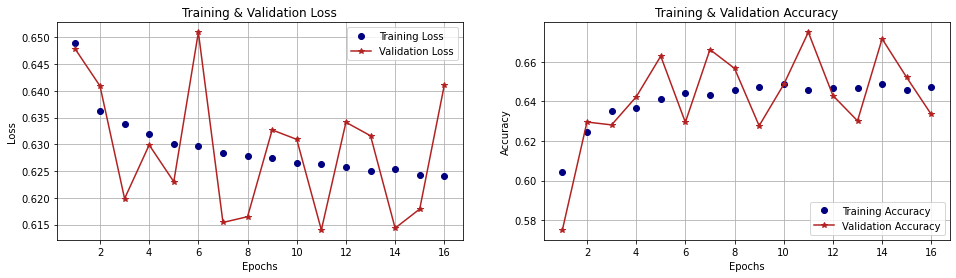

In [92]:
history = pd.read_csv('{}/lending-club-history.csv'.format(name))
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [93]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.33      0.62      0.43     15658
           1       0.88      0.69      0.77     63386

    accuracy                           0.67     79044
   macro avg       0.60      0.65      0.60     79044
weighted avg       0.77      0.67      0.70     79044



[[ 9700  5958]
 [19735 43651]]


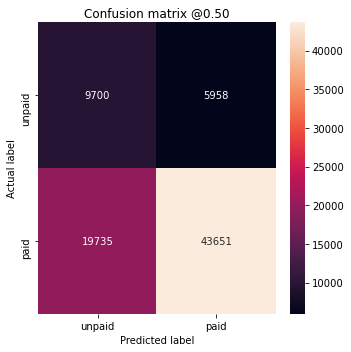

In [94]:
kr.plot_cm(y_test, predictions, ["unpaid", "paid"])

(20.0, 0.0)

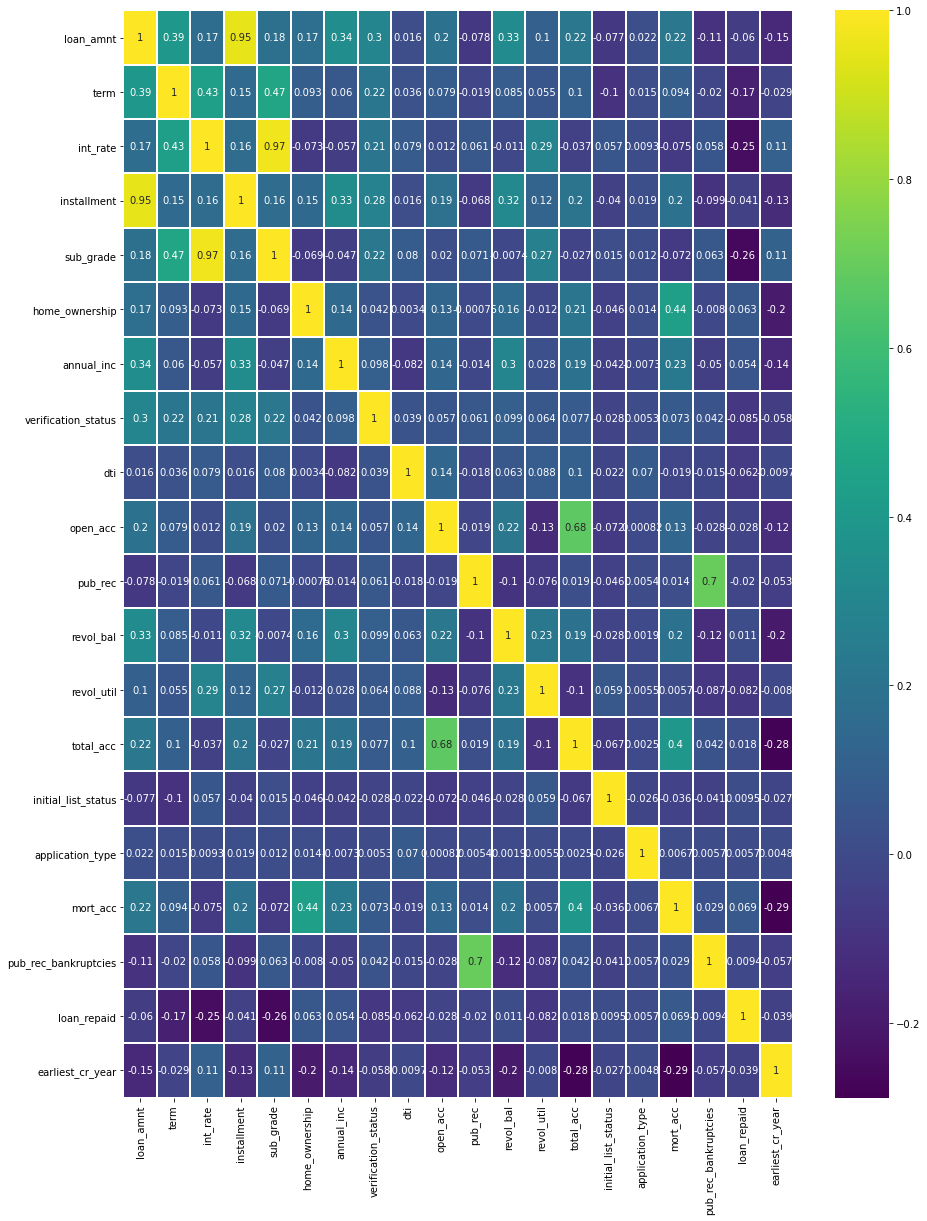

In [95]:
plt.figure(figsize=(15,20))
sns.heatmap(df.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(20, 0)


              precision    recall  f1-score   support

           0       0.33      0.62      0.43     15658
           1       0.88      0.69      0.77     63386

    accuracy                           0.67     79044
   macro avg       0.60      0.65      0.60     79044
weighted avg       0.77      0.67      0.70     79044



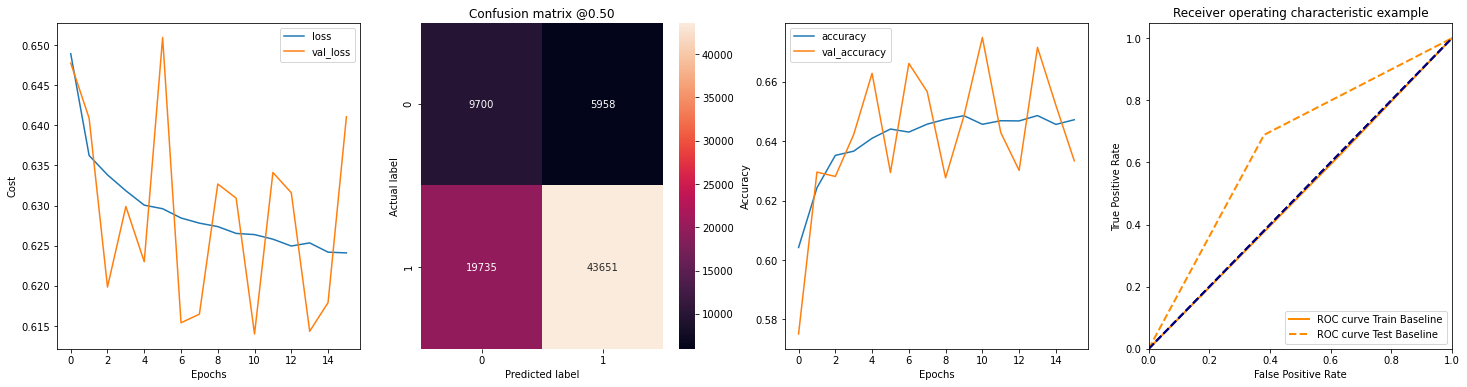

In [96]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def plot_model_results(model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
#     save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train[:len(X_test)]) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
#     save('/building_ann/' + model_name + '.png')
    plt.show()
plot_model_results(model)

In [ ]:
len(X_test)

In [97]:
res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random')].head()


,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
792,0.531096,0.531096,0.000000e+00,1,False,0,auto,random,0.178736,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,0.531096,0.531096,5.960464e-08,1,False,0,auto,random,0.697078,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,0.531096,0.531096,0.000000e+00,1,False,0,auto,random,0.179932,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,0.531096,0.531096,5.960464e-08,1,False,0,auto,random,0.713458,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796,0.531096,0.531096,0.000000e+00,1,False,0,auto,random,0.182348,last,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

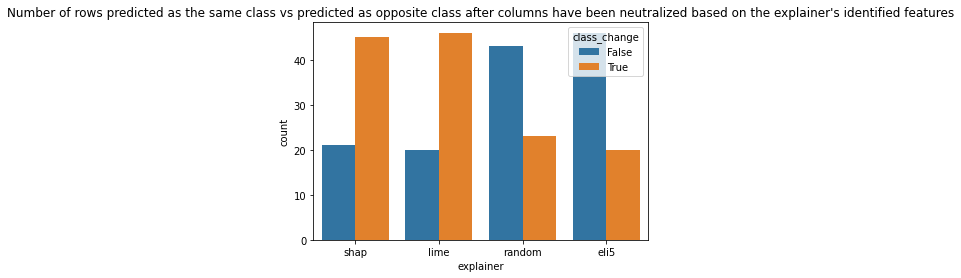

In [98]:
sns.countplot(x="explainer",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

In [12]:
res.count()

original_probability    6336
new_probability         6336
confidence_diff         6336
original_class          6336
class_change            6336
no_features             6336
nsamples                6336
explainer               6336
time                    6336
reverse_order           6336
i0                      5760
i1                      5184
i2                      4608
i3                      4032
i4                      3456
i5                      2880
i6                      2304
i7                      1728
i8                      1152
i9                       576
i10                        0
dtype: int64

In [85]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'earliest_cr_year'],
      dtype='object')

                      0
0              int_rate
1                  term
2            annual_inc
3              open_acc
4                   dti
5             revol_bal
6   initial_list_status
7               pub_rec
8             sub_grade
9              open_acc
10     earliest_cr_year
11           revol_util
12              pub_rec


Text(0.5, 1.0, 'Random - Contplot across all feature importances')

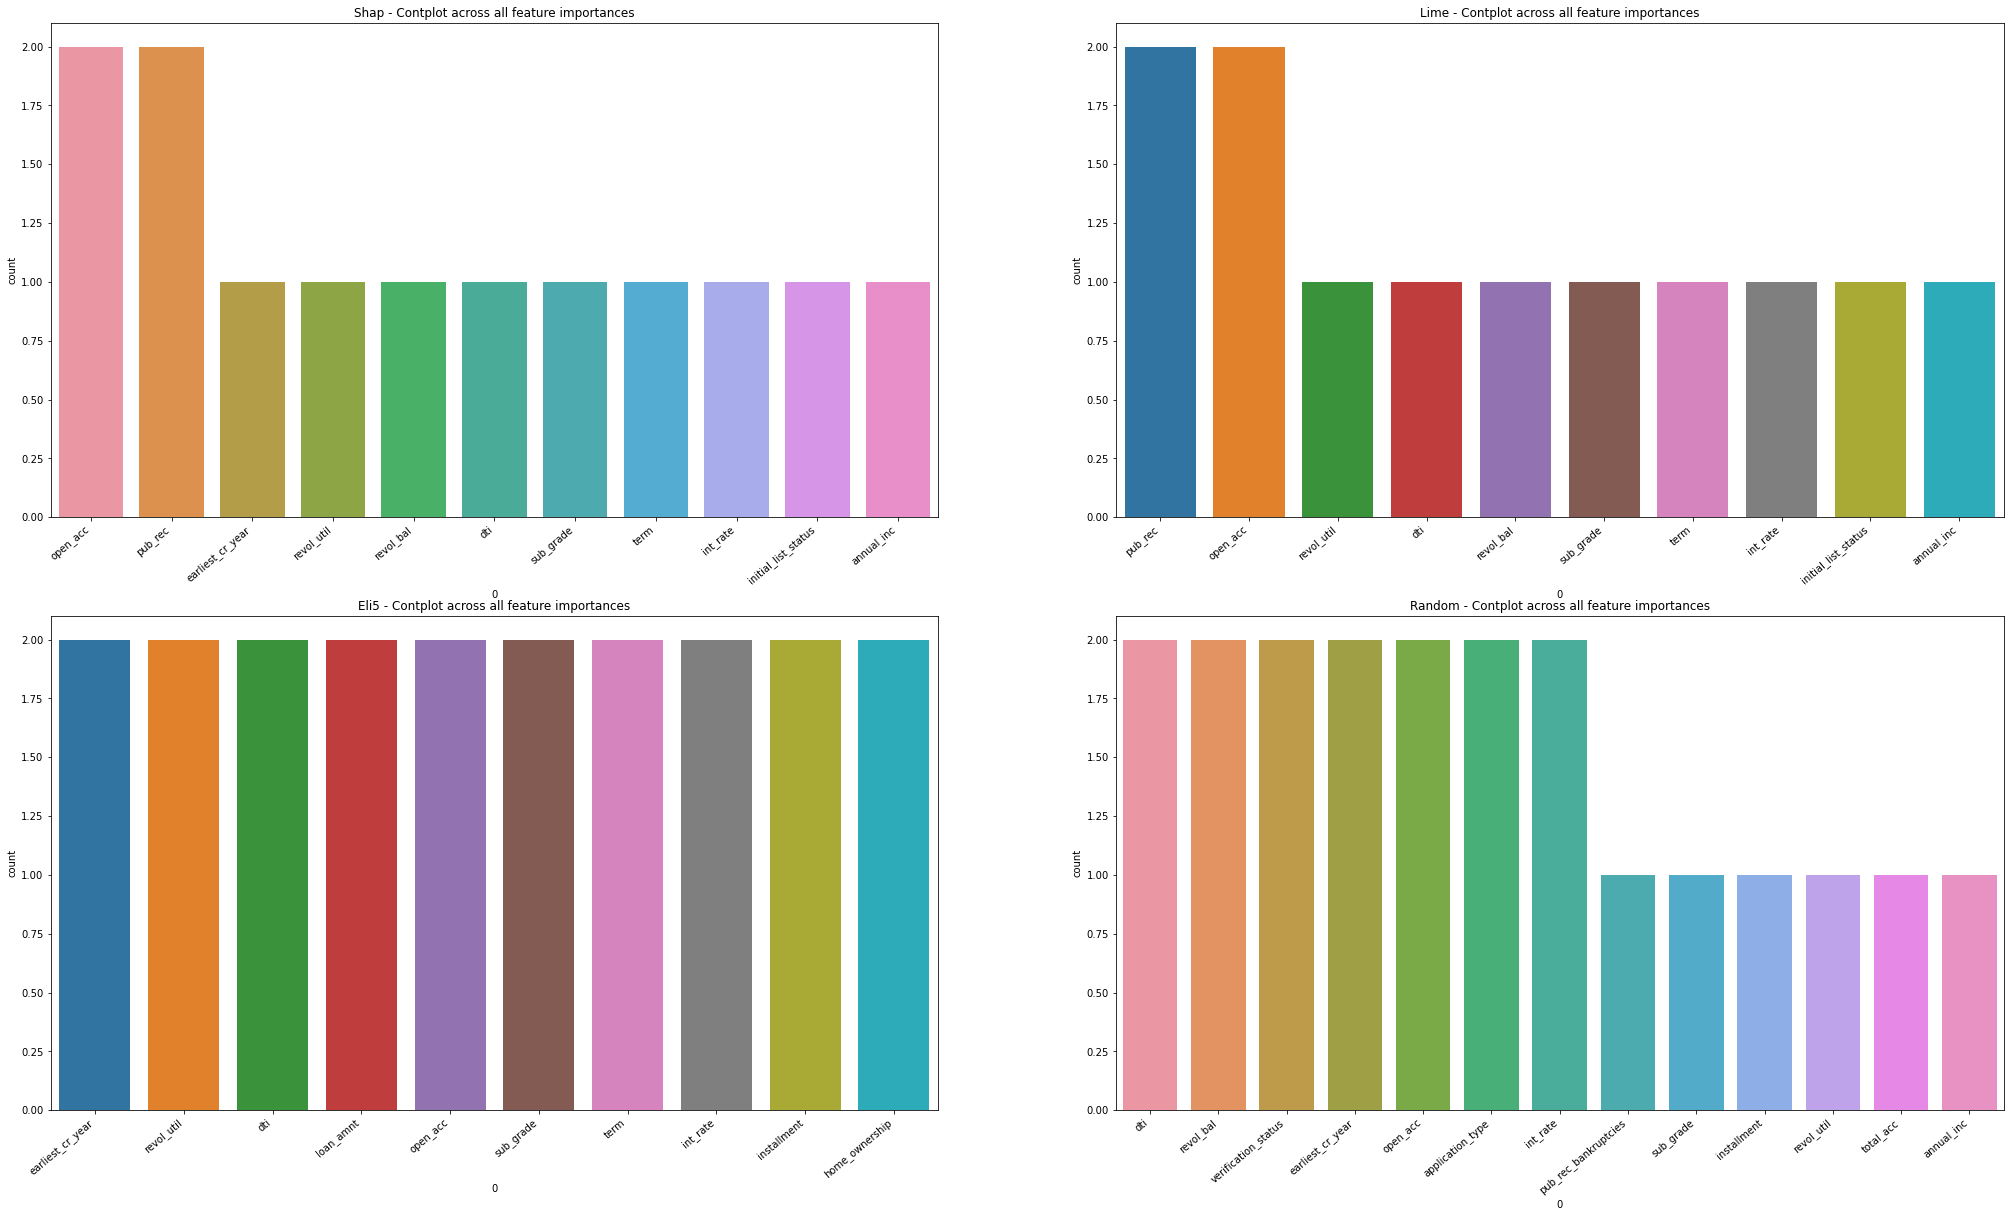

<Figure size 1800x288 with 0 Axes>

In [103]:
def get_countplot(explainer, feature_rankings="first"):
    columns = df.drop('loan_repaid', axis=1).columns
    result = res[(res['nsamples'] == 'auto') & (res['explainer'] == explainer) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution') & (res["no_features"]==10)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","feature_rankings", "strategy"],axis=1)
    result.columns = [''] * len(result.columns)
#     result = result.dropna()
    flat_list = pd.DataFrame([columns[int(item)] for sublist in result.values.tolist() for item in sublist if not pd.isnull(item)])
    return flat_list

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))
reverse_order = "first"
plt.figure(figsize=(25,4))

countplot_list = get_countplot("shap", "first")
# print(countplot_list)
ax[0][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=40, ha="right")
ax[0][0].set_title("Shap - Contplot across all feature importances")

countplot_list = get_countplot("lime")
ax[0][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=40, ha="right")
ax[0][1].set_title("Lime - Contplot across all feature importances")

countplot_list = get_countplot("eli5")
ax[1][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=40, ha="right")
ax[1][0].set_title("Eli5 - Contplot across all feature importances")

countplot_list = get_countplot("random")
ax[1][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=40, ha="right")
ax[1][1].set_title("Random - Contplot across all feature importances")

Text(0.5, 1.0, 'Random')

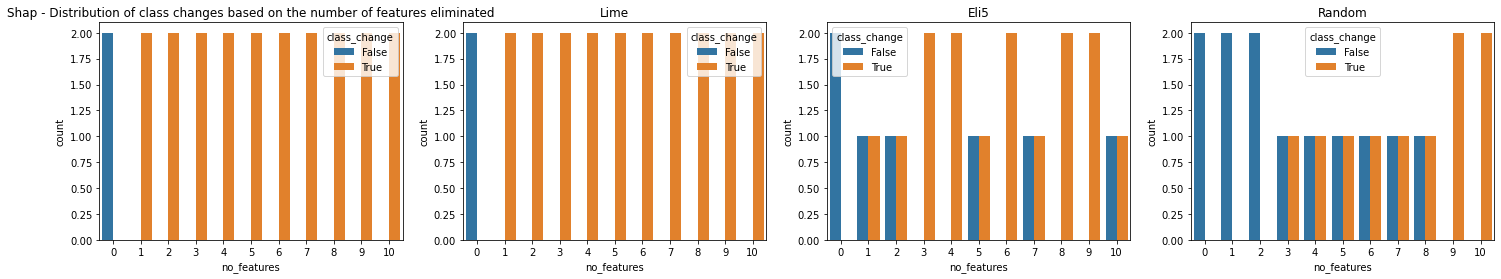

In [104]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')]

ax[0]=sns.countplot(x="no_features",data=data[data['explainer'] == 'shap'], hue = 'class_change', ax = ax[0])
ax[0].set_title("Shap - Distribution of class changes based on the number of features eliminated")

ax[1]=sns.countplot(x="no_features",data=data[data['explainer'] == 'lime'], hue = 'class_change', ax = ax[1])
ax[1].set_title("Lime")

ax[2]=sns.countplot(x="no_features",data=data[data['explainer'] == 'eli5'], hue = 'class_change', ax = ax[2])
ax[2].set_title("Eli5")

ax[3]=sns.countplot(x="no_features",data=data[data['explainer'] == 'random'], hue = 'class_change', ax = ax[3])
ax[3].set_title("Random")

In [ ]:
res[(res['nsamples'] == 'auto')]

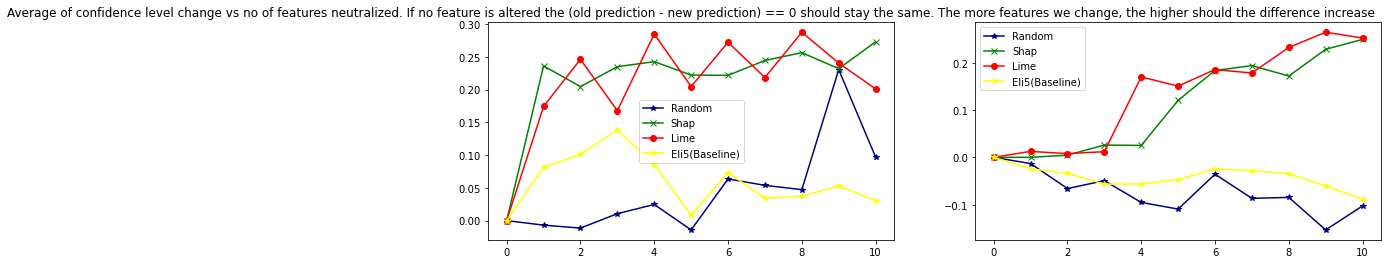

In [112]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, feature_rankings ):
    data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", "first")) ))
ax[0].plot( no_of_features,  get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", feature_rankings) , color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", feature_rankings) , color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings) , color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[0].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[0].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features,get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
# ax[1].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[1].legend(loc='best')

In [113]:
res[(res['nsamples'] == 'auto') ].groupby("no_features")["confidence_diff"].mean() 

no_features
0     1.490116e-08
1     4.131629e-02
2     5.117230e-02
3     5.966393e-02
4     9.429855e-02
5     9.353688e-02
6     1.012001e-01
7     1.031046e-01
8     1.258875e-01
9     1.350257e-01
10    1.105614e-01
Name: confidence_diff, dtype: float64

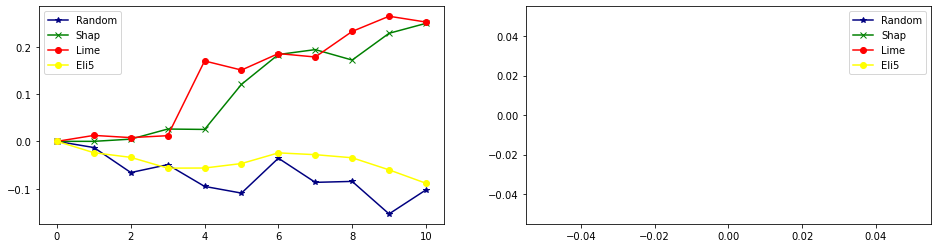

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [119]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, feature_rankings ):
    data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

original_class = 1
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class)  &(res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[0].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].legend(loc='best')

original_class = 0
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  &(res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].legend(loc='best')

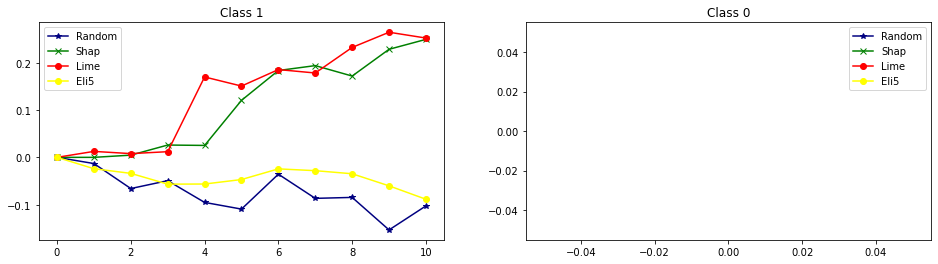

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [122]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, original_class):
    default_data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return default_data[(default_data['explainer'] == explainer) & (default_data['original_class'] == original_class)].groupby("no_features")["confidence_diff"].mean()

original_class = 1
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(get_data("random", original_class)) ))
ax[0].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Class {}".format(original_class))
ax[0].legend(loc='best')

original_class = 0
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Class {}".format(original_class))
ax[1].legend(loc='best')

In [ ]:
res[res["original_class"] == 0].head(5)

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


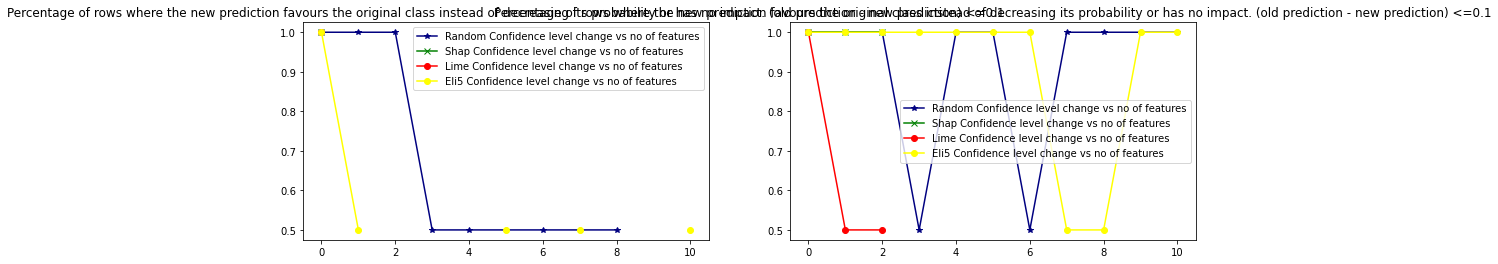

In [126]:
def get_data(explainer, feature_rankings):
    data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')] 
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[0].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[0].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[0].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[1].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[1].legend(loc='best')

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


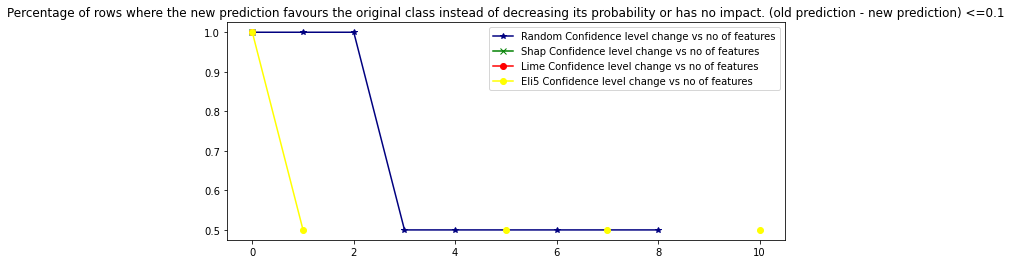

In [129]:
def get_data(explainer):
    data = res[(res['nsamples'] == 'auto')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution') ]
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

plt.figure(figsize=(10,4))
no_of_features = list(range(0, len(get_data("shap")) ))
plt.plot( no_of_features, get_data("random"), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
plt.plot( no_of_features, get_data("shap"), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
plt.plot( no_of_features, get_data("lime"), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
plt.plot( no_of_features, get_data("eli5"), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
plt.title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
plt.legend(loc='best')

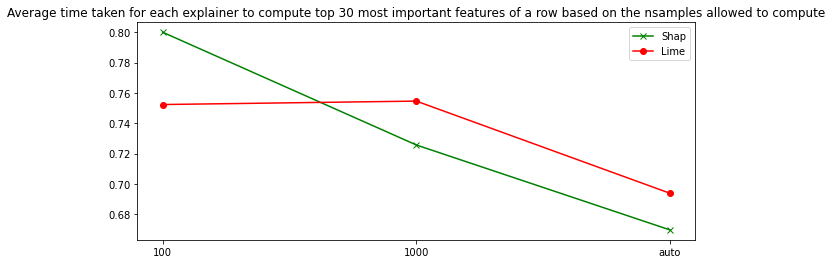

In [138]:
avg_shap = res[(res["no_features"]==10) & (res['explainer'] == 'shap')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')].groupby("nsamples")["time"].mean()
avg_lime = res[(res["no_features"]==10) & (res['explainer'] == 'lime')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')].groupby("nsamples")["time"].mean()

plt.figure(figsize=(10,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_shap)))
# plt.plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
plt.plot( avg_lime.keys(), avg_shap, color='green', marker='x', linestyle='-', label='Shap')
plt.plot( avg_lime.keys(), avg_lime, color='red', marker='o', linestyle='-', label='Lime')
plt.title("Average time taken for each explainer to compute top 30 most important features of a row based on the nsamples allowed to compute")
plt.legend(loc='best')

In [140]:
avg_shap

nsamples
100     0.799965
1000    0.725621
auto    0.669606
Name: time, dtype: float64

In [141]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():       
    return model
# X_train_unscaled, X_test_unscaled, y_train, y_test
# train_x, val_x, train_y, val_y
my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X_test, y_test)

perm = PermutationImportance(my_model).fit(X_test[0:1000],y_test[0:1000])
eli5.show_weights(perm, feature_names = list(df.drop('loan_repaid', axis=1).columns))

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


32/32 [==============================] - 0s 2ms/step - loss: 0.4501 - accuracy: 0.8090 - f1: 0.8916


Weight,Feature
0.1079 ± 0.0211,sub_grade
0.0061 ± 0.0018,open_acc
0.0051 ± 0.0059,term
0.0051 ± 0.0054,int_rate
0.0021 ± 0.0009,verification_status
0.0017 ± 0.0009,earliest_cr_year
0.0014 ± 0.0040,home_ownership
0.0012 ± 0.0013,loan_amnt
0.0010 ± 0.0011,dti
0.0008 ± 0.0003,installment


In [145]:
columns = list(df.drop('loan_repaid', axis=1).columns)
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, class_names=list(['Charged off', 'Fully paid']), feature_names= list(df.drop('loan_repaid', axis=1).columns))
exp = explainer_lime.explain_instance(X_test[row_number], model.predict, num_features=30, top_labels=30)  
exp.show_in_notebook(show_table=True, show_all=False)
model.predict()


                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


TypeError: predict() missing 1 required positional argument: 'x'

In [ ]:
# eli5.show_prediction(model, X_test[row_number].reshape(1, X_test.shape[1]))

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


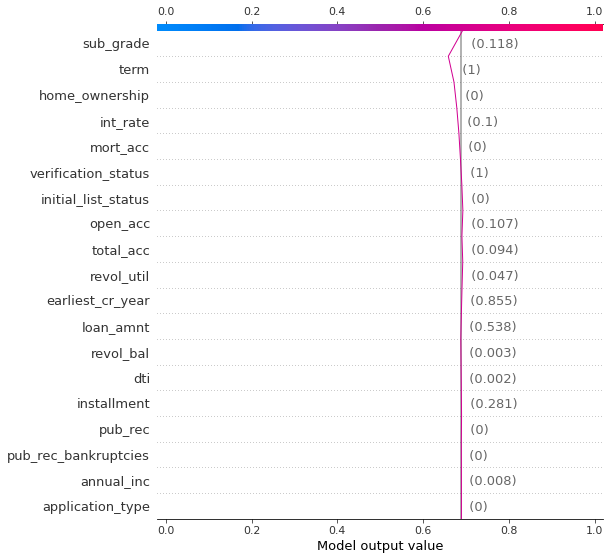

In [142]:
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html -- types of plots available for shap
import shap
def predict_fn(x):
    preds = model.predict(x).reshape(-1, 1)
    p0 = 1 - preds
    return np.hstack((p0, preds))
row_number=2
explainer_shap = shap.KernelExplainer(model.predict, X_train[0:1000])
shap_values = explainer_shap.shap_values(X_test[row_number].reshape(1, X_test.shape[1]), nsamples="auto", l1_reg="num_features(30)")

shap.decision_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [143]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [146]:
df.drop('loan_repaid', axis=1).columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'earliest_cr_year'],
      dtype='object')

In [147]:
X_test[row_number]

array([0.53846154, 1.        , 0.10011687, 0.2807641 , 0.11764706,
       0.        , 0.00820069, 1.        , 0.00212921, 0.10666667,
       0.        , 0.00298979, 0.04673316, 0.09395973, 0.        ,
       0.        , 0.        , 0.        , 0.85507246])

In [ ]:
# %tensorboard --logdir "logs\\hparam_tuning\\2020-07-04-2313" --host localhost --port 8080

In [ ]:
explainer_shap.expected_value

In [148]:
class_avg_1 = [a for a in y_test if a  ==1]
sum(class_avg_1)/len(y_train)
# class_avg_1
model.predict(X_test[row_number].reshape(1, X_test.shape[1]))

array([[0.80835634]], dtype=float32)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

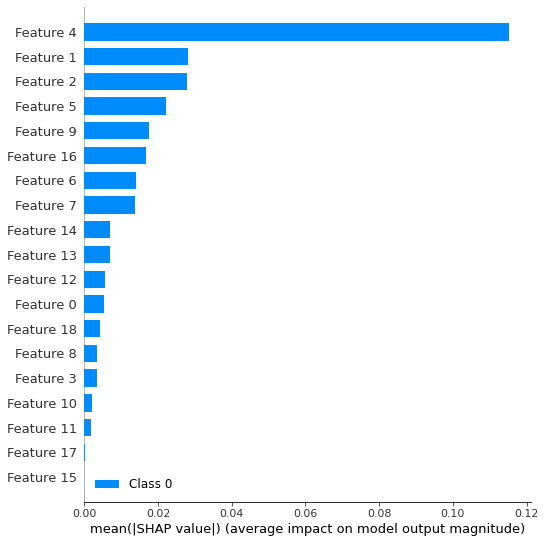

In [150]:
global_shap_values = explainer_shap.shap_values(X_test[0:10])
shap.summary_plot(global_shap_values, X_test[0:10])

In [ ]:
help(shap.summary_plot)

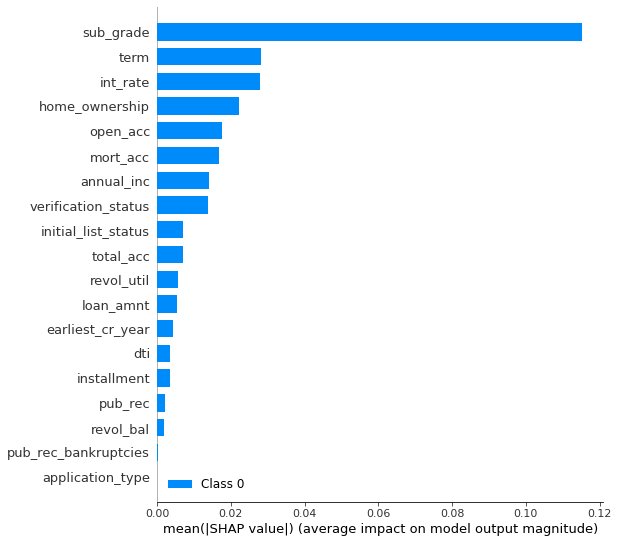

In [151]:
shap.summary_plot(global_shap_values, X_test[0:10], plot_type="bar", feature_names=list(df.drop('loan_repaid', axis=1).columns))

In [154]:
%reload_ext tensorboard
%tensorboard --logdir "ray_res/" 

Reusing TensorBoard on port 6006 (pid 18904), started 0:23:06 ago. (Use '!kill 18904' to kill it.)

In [ ]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))